---
# Algoritmos para Big Data – Projeto
## Parte 2: Análise Exploratória de Dados

**Dataset:** Flight Delay Dataset (limpo da Parte 1)

**Autores:**
- Henrique Niza (131898)
- Paulo Francisco Pinto (128962)
- Rute Roque (128919)

Spark Setup e Leitura dos Dados Limpos

In [2]:
# Importação de bibliotecas necessárias para Spark e visualização
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.window import Window

import matplotlib.pyplot as plt
import seaborn as sns

# Criação da SparkSession
spark = SparkSession.builder.appName("FlightDelayEDA").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/05/24 20:26:33 WARN Utils: Your hostname, MacBook-Pro-de-admin.local, resolves to a loopback address: 127.0.0.1; using 192.168.68.50 instead (on interface en0)
25/05/24 20:26:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/24 20:26:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/24 20:26:34 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/05/24 20:26:34 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
# Leitura dos dados limpos de 2018 a 2022 a partir do ficheiro Parquet
input_path = "../data/processed/flights_cleaned_sample.parquet"
data = spark.read.parquet(input_path)

Verificação Inicial

In [4]:
# Mostrar primeiras linhas, schema e número de linhas do dataset
data.show(5)
data.printSchema()
print(f"Total de linhas: {data.count()}")

25/05/24 20:26:46 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+-----------------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+----------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+
|FlightDate|          Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|DepDelay|Ar

In [5]:
# Verificar balanceamento da variável alvo
data.groupBy("DepDel15").count().orderBy("DepDel15").show()

+--------+-------+
|DepDel15|  count|
+--------+-------+
|     0.0|7034174|
|     1.0|1466460|
+--------+-------+



Feature Engineering: Data de Voo

In [6]:
# Conversão da coluna de data em timestamp e criação do nome do dia da semana
data = data.withColumn("FlightDateTS", F.to_timestamp("FlightDate", "yyyy-MM-dd"))
data = data.withColumn("FlightWeekdayName", F.date_format("FlightDateTS", "EEEE"))

Estatísticas Descritivas

In [7]:
# Cálculo dos valores mínimo, máximo e médio para atrasos
data.select(
    F.min("DepDelay"), F.max("DepDelay"), F.avg("DepDelay"),
    F.min("ArrDelay"), F.max("ArrDelay"), F.avg("ArrDelay")
).show()

+-------------+-------------+-----------------+-------------+-------------+-----------------+
|min(DepDelay)|max(DepDelay)|    avg(DepDelay)|min(ArrDelay)|max(ArrDelay)|    avg(ArrDelay)|
+-------------+-------------+-----------------+-------------+-------------+-----------------+
|       -611.0|       7223.0|9.267027494655105|       -475.0|       7232.0|3.644441696936958|
+-------------+-------------+-----------------+-------------+-------------+-----------------+



In [8]:
# Estatísticas descritivas gerais sobre atraso e distância
data.describe(["DepDelay", "ArrDelay", "Distance"]).show()

+-------+-----------------+-----------------+-----------------+
|summary|         DepDelay|         ArrDelay|         Distance|
+-------+-----------------+-----------------+-----------------+
|  count|          8500634|          8500634|          8500634|
|   mean|9.267027494655105|3.644441696936958|781.5317904523357|
| stddev|47.28007620022302|49.44901375522702| 582.536227195079|
|    min|           -611.0|           -475.0|             29.0|
|    max|           7223.0|           7232.0|           5812.0|
+-------+-----------------+-----------------+-----------------+



Atraso Médio por Companhia

In [9]:
# Agregação do atraso médio por companhia aérea
df_airline = data.groupBy("Airline").agg(
    F.avg("DepDelay").alias("AvgDepDelay"),
    F.avg("ArrDelay").alias("AvgArrDelay")
)
df_airline.orderBy(F.desc("AvgArrDelay")).show()

+--------------------+------------------+------------------+
|             Airline|       AvgDepDelay|       AvgArrDelay|
+--------------------+------------------+------------------+
|Commutair Aka Cha...|19.087563246851115| 16.43369846054473|
|Peninsula Airways...|16.513708513708515|  14.3997113997114|
|Trans States Airl...|16.916035625161346| 14.36588933826693|
|       Allegiant Air|12.495513081779894|11.241456979213591|
|     JetBlue Airways|15.927254282718355|10.234065061332373|
|ExpressJet Airlin...|12.220463305278061|  9.50133721387556|
|Frontier Airlines...|13.462734033141246| 8.171600392147486|
|  Mesa Airlines Inc.|12.319369788556005| 8.088980559375159|
|GoJet Airlines, L...|12.396921193037699| 7.042720945633567|
|    Spirit Air Lines|10.400800733596423| 5.263947338256726|
|    Compass Airlines| 9.486479390916251| 5.212260435809924|
|Air Wisconsin Air...| 9.415982430080286| 4.864443695150958|
|United Air Lines ...|10.138295791281163|4.5688906921310215|
|American Airlines...|10

Visualização: Atraso Médio por Companhia

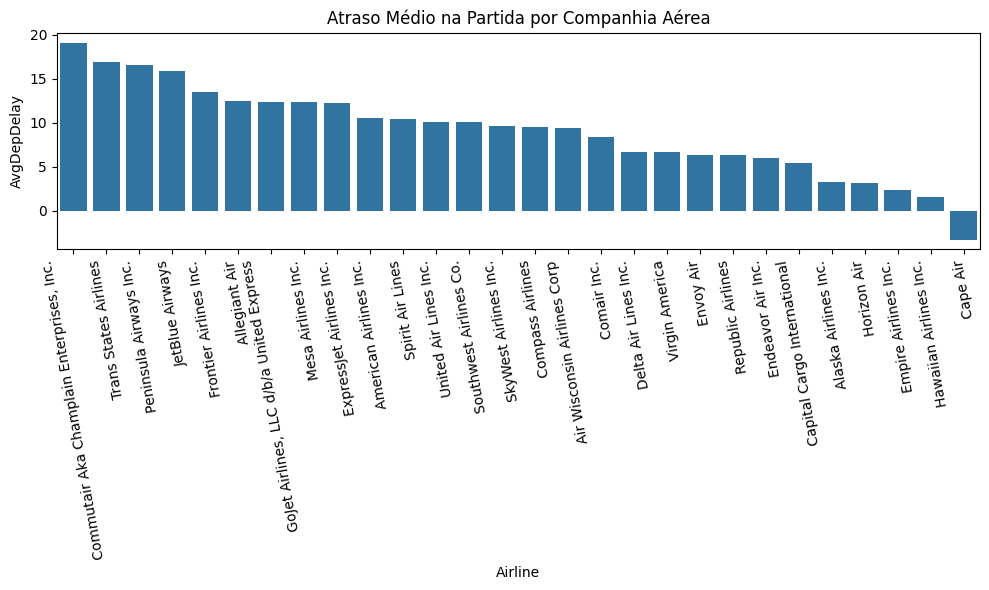

In [13]:
# Conversão para Pandas e criação do gráfico de barras
df_plot = df_airline.toPandas().sort_values("AvgDepDelay", ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(data=df_plot, x="Airline", y="AvgDepDelay")
plt.xticks(rotation=100)
plt.title("Atraso Médio na Partida por Companhia Aérea")
plt.tight_layout()
plt.show()

Atraso Médio por Origem

In [14]:
# Agregação do atraso médio por aeroporto de origem
df_origin = data.groupBy("Origin").agg(
    F.avg("DepDelay").alias("AvgDepDelay")
)
df_origin.orderBy(F.desc("AvgDepDelay")).show()

+------+------------------+
|Origin|       AvgDepDelay|
+------+------------------+
|   YNG|             111.0|
|   PPG| 47.57954545454545|
|   BIH| 30.21212121212121|
|   PQI|25.287319422150883|
|   OGS|24.726978998384492|
|   ILG|23.448979591836736|
|   BLV|23.333110814419225|
|   MMH| 22.80456026058632|
|   HYA|22.571428571428573|
|   MEI|22.402838427947597|
|   ACK|  21.5750452079566|
|   ASE| 21.01193989804132|
|   DDC| 20.49448123620309|
|   MQT|20.483247422680414|
|   UIN| 20.39344262295082|
|   HGR|19.824489795918367|
|   XWA|19.639448568398727|
|   RIW| 19.41304347826087|
|   LCK|19.109255393180238|
|   CKB|18.594381035996488|
+------+------------------+
only showing top 20 rows


Visualização: Atraso Médio por Aeroporto de Origem (Top 20)

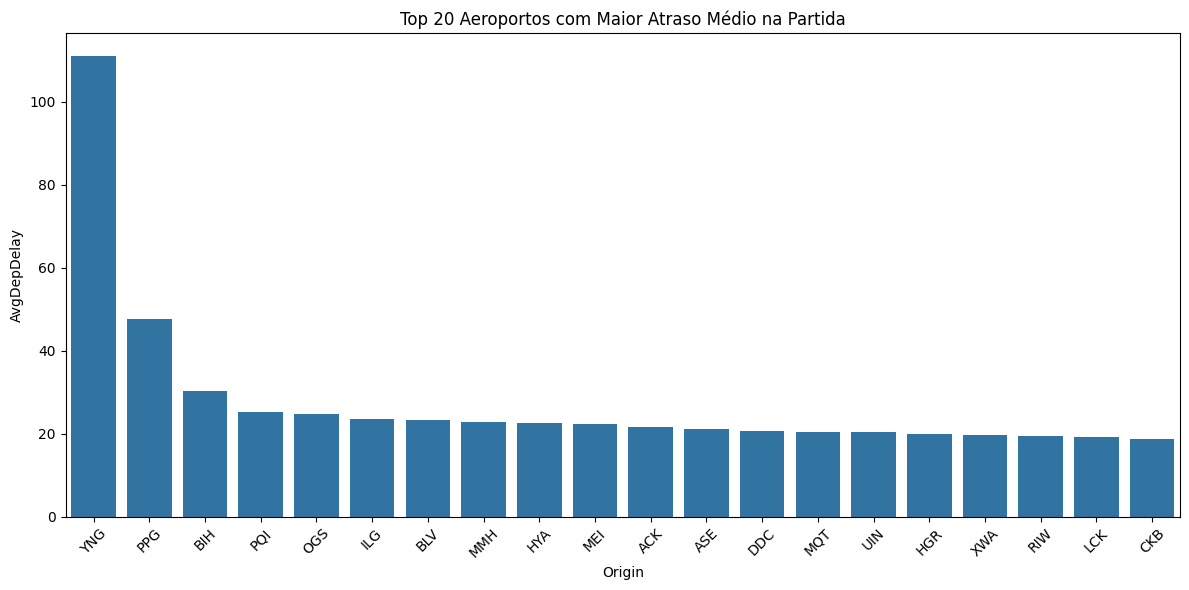

In [15]:
# Conversão para Pandas e gráfico dos 20 aeroportos com maior atraso
df_origin_pd = df_origin.toPandas().sort_values("AvgDepDelay", ascending=False).head(20)
plt.figure(figsize=(12,6))
sns.barplot(data=df_origin_pd, x="Origin", y="AvgDepDelay")
plt.xticks(rotation=45)
plt.title("Top 20 Aeroportos com Maior Atraso Médio na Partida")
plt.tight_layout()
plt.show()

Atraso Acumulado por Companhia (Running Total)

In [16]:
# Cálculo do atraso acumulado (soma cumulativa) por companhia aérea
window_spec = Window.partitionBy("Airline").orderBy("FlightDateTS")
data = data.withColumn("CumDepDelay", F.sum("DepDelay").over(window_spec))

In [17]:
# Visualização dos resultados acumulados por companhia
data.select("Airline", "FlightDateTS", "DepDelay", "CumDepDelay").orderBy("Airline", "FlightDateTS").show(5)

+--------------------+-------------------+--------+-----------+
|             Airline|       FlightDateTS|DepDelay|CumDepDelay|
+--------------------+-------------------+--------+-----------+
|Air Wisconsin Air...|2018-01-01 00:00:00|   188.0|     3444.0|
|Air Wisconsin Air...|2018-01-01 00:00:00|    70.0|     3444.0|
|Air Wisconsin Air...|2018-01-01 00:00:00|   -11.0|     3444.0|
|Air Wisconsin Air...|2018-01-01 00:00:00|    -8.0|     3444.0|
|Air Wisconsin Air...|2018-01-01 00:00:00|   234.0|     3444.0|
+--------------------+-------------------+--------+-----------+
only showing top 5 rows


Atraso Anterior por Origem

In [18]:
# Obtenção do atraso do voo anterior no mesmo aeroporto de origem
window_origin = Window.partitionBy("Origin").orderBy("FlightDateTS")
data = data.withColumn("PrevDepDelay", F.lag("DepDelay", 1).over(window_origin))

In [19]:
# Visualização do atraso anterior por origem
data.select("Origin", "FlightDateTS", "DepDelay", "PrevDepDelay").orderBy("Origin", "FlightDateTS").show(5)

+------+-------------------+--------+------------+
|Origin|       FlightDateTS|DepDelay|PrevDepDelay|
+------+-------------------+--------+------------+
|   ABE|2018-01-02 00:00:00|   561.0|        NULL|
|   ABE|2018-01-03 00:00:00|     9.0|       561.0|
|   ABE|2018-01-03 00:00:00|    26.0|         9.0|
|   ABE|2018-01-04 00:00:00|   222.0|        26.0|
|   ABE|2018-01-04 00:00:00|    -1.0|       222.0|
+------+-------------------+--------+------------+
only showing top 5 rows


Rank de Atraso por Destino

In [20]:
# Cálculo do ranking de atraso por aeroporto de destino
window_dest = Window.partitionBy("Dest").orderBy(F.desc("ArrDelay"))
data = data.withColumn("RankedDelay", F.rank().over(window_dest))

In [21]:
# Visualização do ranking de atraso por destino
data.select("Dest", "ArrDelay", "RankedDelay").orderBy("Dest", "RankedDelay").show(5)

+----+--------+-----------+
|Dest|ArrDelay|RankedDelay|
+----+--------+-----------+
| ABE|   737.0|          1|
| ABE|   642.0|          2|
| ABE|   621.0|          3|
| ABE|   595.0|          4|
| ABE|   582.0|          5|
+----+--------+-----------+
only showing top 5 rows


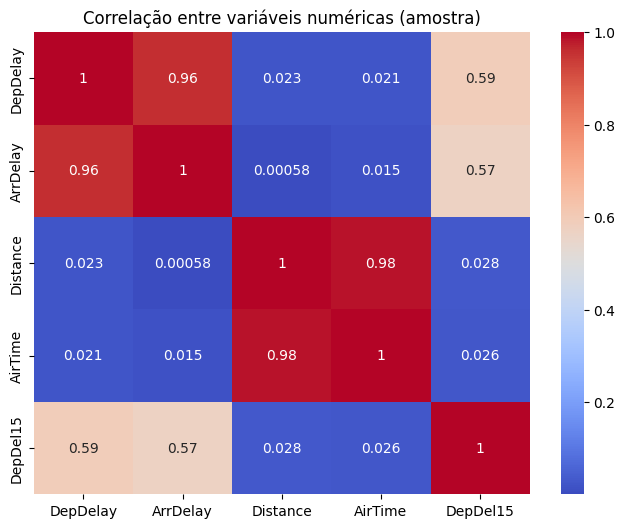

In [24]:
# Análise de correlação entre variáveis numéricas (com amostragem)
cols_corr = ["DepDelay", "ArrDelay", "Distance", "AirTime", "DepDel15"]
df_corr = data.select(cols_corr).dropna().sample(fraction=0.005, seed=42).toPandas()  # ~40k linhas

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(df_corr.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlação entre variáveis numéricas (amostra)")
plt.show()

Dados preparados para as fases seguintes: modelação e previsão de atrasos.